In [1]:
from rdflib.extras.external_graph_libs import *
from rdflib import Graph, URIRef, Literal

import networkx as nx
from networkx.classes.function import info

import stellargraph as sg
from stellargraph.mapper import RelationalFullBatchNodeGenerator
from stellargraph.layer import RGCN

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from sklearn import preprocessing, model_selection
import sklearn
from sklearn import model_selection
from collections import Counter
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
graph = nx.read_gml('no_relations_graph_gcn.gml')
node_subjects = nx.get_node_attributes(graph,'table_name')

In [3]:
print(type(node_subjects))

<class 'dict'>


In [4]:
counter =0
list_of_ids =[]
for key, value in node_subjects.items():
    if len(value) != 0:
        list_of_ids.append(counter)
    counter +=1

In [5]:
index_list = [*range(0, 2420, 1)] 
node_subjects= pd.Series(list(node_subjects.values())[0:len(list_of_ids)], index = index_list, name= "table_name")
print(node_subjects)

0       classroom
1       classroom
2       classroom
3       classroom
4       classroom
          ...    
2415    time_slot
2416    time_slot
2417    time_slot
2418    time_slot
2419    time_slot
Name: table_name, Length: 2420, dtype: object


In [6]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.8, test_size=None, stratify=node_subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=0.5, test_size=None, stratify=test_subjects
)

In [7]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

In [8]:
#BASE CASE( assigning a constant vector to every node) 
#print(counter)
#matrix=[]
#for i in range(counter):
#    vecForEach = np.ones(counter) 
#    matrix.append(vecForEach)

#index = [*range(0,counter,1)]
#list_of_tuples = list(zip(index, matrix))
#df = pd.DataFrame(list_of_tuples, 
#                  columns = ['index', 'value'])   


#df

6729


,index,value
0,0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,1,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,2,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,3,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,4,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
...,...,...
6724,6724,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
6725,6725,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
6726,6726,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
6727,6727,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [9]:
print(counter)
matrix=[]
for i in range(counter):
    vecForEach = np.zeros(counter)
    vecForEach[i] =1
    matrix.append(vecForEach)

index = [*range(0,counter,1)]
list_of_tuples = list(zip(index, matrix))
df = pd.DataFrame(list_of_tuples, 
                  columns = ['index', 'value'])   


df

6729


,index,value
0,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...
6724,6724,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6725,6725,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6726,6726,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6727,6727,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [10]:
i=0
for u,outer_d in graph.nodes(data=True):
    #print(type(df.iloc[i]['value']))
    outer_d['val'] = df.iloc[i]['value']
    i+=1

In [11]:
G = sg.StellarGraph.from_networkx(graph,node_features="val")
G.info()

'StellarGraph: Undirected multigraph\n Nodes: 6729, Edges: 44646\n\n Node types:\n  default: [6729]\n    Features: float32 vector, length 6729\n    Edge types: default-default->default\n\n Edge types:\n    default-default->default: [44646]\n        Weights: range=[0.0895506, 1.02161], mean=0.892291, std=0.221327\n        Features: none'

In [12]:
__all__ = [
    "FullBatchGenerator",
    "FullBatchNodeGenerator",
    "FullBatchLinkGenerator",
    "RelationalFullBatchNodeGenerator",
]

import warnings
import operator
import random
import numpy as np
import itertools as it
import networkx as nx
import scipy.sparse as sps
from tensorflow.keras import backend as K
from functools import reduce
from tensorflow.keras.utils import Sequence
from stellargraph.mapper import (
    Generator,
    FullBatchSequence,
    SparseFullBatchSequence,
    RelationalFullBatchNodeSequence,
    GraphSAGENodeGenerator,
    DirectedGraphSAGENodeGenerator,
)

from stellargraph.core.graph import StellarGraph
from stellargraph.core.utils import is_real_iterable
from stellargraph.core.utils import GCN_Aadj_feats_op, PPNP_Aadj_feats_op
from stellargraph.core.validation import comma_sep

class RelationalFullBatchNodeGenerator2(Generator):
    def __init__(self, G, name=None, sparse=True, transform=None, weighted=False):

        if not isinstance(G, StellarGraph):
            raise TypeError("Graph must be a StellarGraph object.")

        self.graph = G
        self.name = name
        self.use_sparse = sparse
        self.multiplicity = 1

        # Check if the graph has features
        G.check_graph_for_ml()

        # extract node, feature, and edge type info from G
        node_types = list(G.node_types)
        if len(node_types) != 1:
            raise ValueError(
                f"G: expected one node type, found {comma_sep(sorted(node_types))}",
            )

        self.features = G.node_features(node_type=node_types[0])

        # create a list of adjacency matrices - one adj matrix for each edge type
        # an adjacency matrix is created for each edge type from all edges of that type
        self.As = []

        for edge_type in G.edge_types:
            # note that A is the transpose of the standard adjacency matrix
            # this is to aggregate features from incoming nodes
            A = G.to_adjacency_matrix(
                edge_type=edge_type, weighted=weighted
            ).transpose()

            if transform is None:
                # normalize here and replace zero row sums with 1
                # to avoid harmless divide by zero warnings
                d = sps.diags(
                    np.float_power(np.ravel(np.maximum(A.sum(axis=1), 1)), -1), 0
                )
                A = d.dot(A)

            else:
                self.features, A = transform(self.features, A)

            A = A.tocoo()
            self.As.append(A)

    def num_batch_dims(self):
        return 2


    def flow(self, node_ids, targets=None):
        if targets is not None:
            # Check targets is an iterable
            if not is_real_iterable(targets):
                raise TypeError("Targets must be an iterable or None")

            # Check targets correct shape
            if len(targets) != len(node_ids):
                raise TypeError("Targets must be the same length as node_ids")

        #node_indices = self.graph.node_ids_to_ilocs(node_ids)
        node_ids = np.asarray(node_ids)
        return RelationalFullBatchNodeSequence(
            self.features, self.As, self.use_sparse, targets, node_ids
        )

    def default_corrupt_input_index_groups(self):
        return [[0]]


In [13]:
train_subject_frame = train_subjects.to_frame()
print(type(train_subject_frame))


<class 'pandas.core.frame.DataFrame'>


In [14]:
generator = RelationalFullBatchNodeGenerator(G, sparse=True,weighted=True)
generator2 = RelationalFullBatchNodeGenerator2(G, sparse=True,weighted=True)
train_gen = generator2.flow(train_subjects.to_frame().index, targets=train_targets) 
test_gen = generator2.flow(test_subjects.to_frame().index, targets=test_targets) 

In [15]:
rgcn = RGCN(
    layer_sizes=[64, 32],
    activations=["relu", "relu"],
    generator=generator,
    bias=True,
    num_bases=20,
    dropout=0.5,
)

In [16]:
x_in, x_out = rgcn.in_out_tensors()
predictions = Dense(train_targets.shape[-1], activation="softmax")(x_out)
model = Model(inputs=x_in, outputs=predictions)
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(0.01),
    metrics=["acc"]
)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(1, 6729, 6729)]    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(1, None, 2)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(1, None)]          0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (1, 6729, 6729)      0           input_1[0][0]                    
______________________________________________________________________________________________

In [18]:
history = model.fit(train_gen, validation_data=test_gen, epochs=40)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1 steps, validate for 1 steps
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.9564 - acc: 0.0253 - val_loss: 1.8500 - val_acc: 0.8264
Epoch 2/40
1/1 [==============================] - 1s 1s/step - loss: 1.8466 - acc: 0.8275 - val_loss: 1.6650 - val_acc: 0.8264
Epoch 3/40
1/1 [==============================] - 1s 1s/step - loss: 1.6523 - acc: 0.8264 - val_loss: 1.3104 - val_acc: 0.8264
Epoch 4/40
1/1 [==============================] - 1s 1s/step - loss: 1.2516 - acc: 0.8264 - val_loss: 0.8375 - val_acc: 0.8264
Epoch 5/40
1/1 [==============================] - 1s 1s/step - loss: 0.7922 - acc: 0.8264 - val_loss: 0.6389 - val_acc: 0.8264
Epoch 6/40
1/1 [==============================] - 1s 1s/step - loss: 0.6356 - acc: 0.8264 - val_loss: 0.7295 - val_acc: 0.8264
Epoch 7/40
1/1 [==============================] - 1s 1s/step - loss: 0.7379 - acc: 0.8264 - val_loss: 0.7506 - val_acc: 0.8264
Epoch 8/40
1/1 [=====

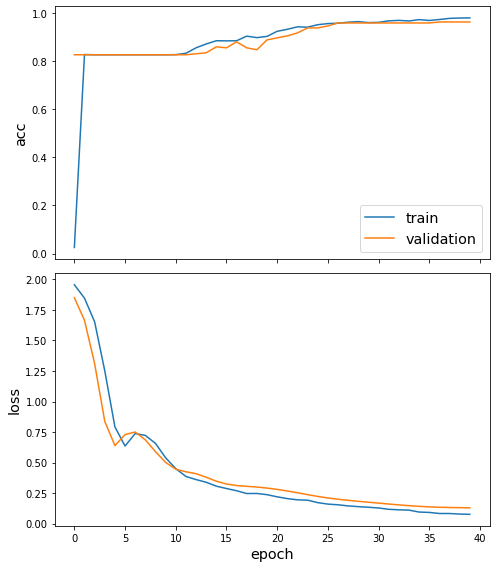

In [19]:
sg.utils.plot_history(history)

In [20]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

  ...
    to  
  ['...']
1/1 [==============================] - 0s 402ms/step - loss: 0.1298 - acc: 0.9628

Test Set Metrics:
	loss: 0.1298
	acc: 0.9628


In [21]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow.keras import layers, optimizers, losses, metrics, Model

# get embeddings for all people nodes
#all_gen = generator2.flow(node_subjects.index, targets=node_subjects)
all_gen = generator2.flow(node_subjects.index, targets=node_subjects)
embedding_model = Model(inputs=x_in, outputs=x_out)
emb = embedding_model.predict(all_gen)
emb.shape
print(emb.shape)
X = emb.squeeze(0)
print(X.shape)
transform = TSNE  # or PCA
trans = transform(n_components=2)
X_reduced = trans.fit_transform(X)
X_reduced.shape

(1, 2420, 32)
(2420, 32)


(2420, 2)

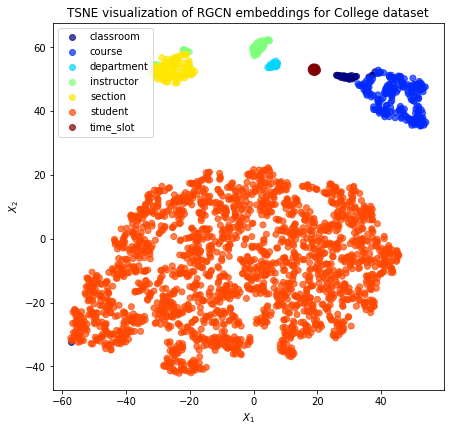

In [22]:
fig, ax = plt.subplots(figsize=(7, 7))
scatter =ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=node_subjects.astype("category").cat.codes,
    cmap="jet",
    alpha=0.7,
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"{transform.__name__} visualization of RGCN embeddings for College dataset",
)
classes = ['classroom', 'course','department','instructor','section', 'student','time_slot']
plt.legend(handles=scatter.legend_elements()[0], labels=classes)